In [1]:
import numpy
import pandas
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.svm

from matplotlib import pyplot
%matplotlib inline

In [3]:
train_data = pandas.read_csv("train.csv.gz").values
X, y = train_data[:, 1:], train_data[:, 0]
print("X:", X.shape)
print("y:", y.shape)

X: (42000, 784)
y: (42000,)


In [11]:
X_test = pandas.read_csv("test.csv.gz").values
print("Test X:", X_test.shape)

Test X: (28000, 784)


# PCA

In [4]:
pca = sklearn.decomposition.PCA().fit(X)

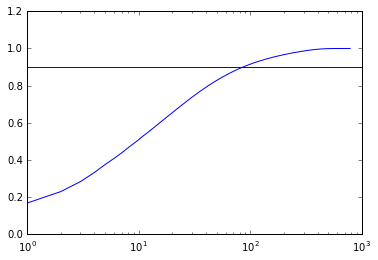

In [5]:
pyplot.plot(numpy.cumsum(pca.explained_variance_ratio_))
pyplot.axhline(y=0.9)
pyplot.xscale("log")
pyplot.show()

In [6]:
X_transformed = pca.transform(X)

# Random Forest

In [10]:
numpy.random.seed(0)

rfc_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt",
), {
    "n_estimators": [500],
    "max_depth": [50, 100],
}, verbose=3).fit(X, y)

print("Score:", rfc_model.best_score_)
print("Params:", rfc_model.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=500, max_depth=50 ..................................
[CV] ......... n_estimators=500, max_depth=50, score=0.963153 - 1.5min
[CV] n_estimators=500, max_depth=50 ..................................
[CV] ......... n_estimators=500, max_depth=50, score=0.963495 - 1.4min
[CV] n_estimators=500, max_depth=50 ..................................
[CV] ......... n_estimators=500, max_depth=50, score=0.966209 - 1.4min
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963510 - 1.9min
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.963566 - 1.5min
[CV] n_estimators=500, max_depth=100 .................................
[CV] ........ n_estimators=500, max_depth=100, score=0.967067 - 1.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.1min finished


Score: 0.964714285714
Params: {'n_estimators': 500, 'max_depth': 100}


In [23]:
y_test = numpy.array(list(enumerate(rfc_model.best_estimator_.predict(X_test), start=1)))
print("Y test:", y_test.shape)
numpy.savetxt("answer_rfc.csv", y_test, fmt="%d,\"%d\"", header="\"ImageId\",\"Label\"", comments="")

Y test: (28000, 2)


# Bayes

In [7]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
    sklearn.naive_bayes.MultinomialNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X, y).mean()))

GaussianNB(): 0.562237774695
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.832999717714
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True): 0.825237642591


## PCA + Bayes

In [8]:
numpy.random.seed(0)

for model in [
    sklearn.naive_bayes.GaussianNB(),
    sklearn.naive_bayes.BernoulliNB(),
]:
    print("%s: %s" % (model, sklearn.cross_validation.cross_val_score(model, X_transformed[:, :100], y).mean()))

GaussianNB(): 0.869833232797
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True): 0.738832880561
